Applied policy gradient method on control environments. Would suggest reading this after the DQN notebook since that was the order I learned these strategies too. 

In [1]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import one_hot, log_softmax, softmax, normalize
from torch.autograd import Variable
from torch.distributions import Categorical
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline



Lots of assistance in setting this up via Pytorch from 

https://github.com/halahup/RL-Primers/blob/master/Policy%20Gradient/policy_gradient.py

In [2]:
#initialize environment, device, and hyperparameters

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')


ALPHA = 0.001 #learning rate
GAMMA = 0.98 #discounting for future events
BETA  = 0. #amount to add to entropy bonus on objective function  


Note: CartPole is one of the games which is one that depends a lot less on a brute force sort of search for the optimal policies, as opposed to a game like MountainCar which eventually finds its way to the goal and works its way back from there. Because of that, I'll save the video for CartPole since it will show the most information in the least amount of time. 

In [3]:

class Policy(nn.Module):
    """
    Neural network to approximate the policy function. 
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        

    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.2),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1) 
        )  #output is log probs
        return model(x)

In [4]:
def get_discounted_rewards(rewards: np.array, gamma: float) -> np.array:
    """
        Calculates the sequence of discounted rewards-to-go.
        Args:
            rewards: the sequence of observed rewards
            gamma: the discount factor
        Returns:
            discounted_rewards: the sequence of the rewards-to-go
    """
    discounted_rewards = np.empty_like(rewards, dtype=np.float)
    for i in range(rewards.shape[0]):
        gammas = np.full(shape=(rewards[i:].shape[0]), fill_value=gamma)
        discounted_gammas = np.power(gammas, np.arange(rewards[i:].shape[0]))
        discounted_reward = np.sum(rewards[i:] * discounted_gammas)
        discounted_rewards[i] = discounted_reward # returns dicounted rewards value at each step in rewards array.
        

        
    return discounted_rewards


def calculate_loss(epoch_logits: torch.Tensor, weighted_log_probs: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """
        Calculates the policy "loss" and the entropy bonus
        Args:
            epoch_logits: logits of the policy network we have collected over m episodes
            weighted_log_probs: loP * W of the actions taken
        Returns:
            policy loss + the entropy bonus
            entropy: for logging
    """
    policy_loss = -1 * torch.mean(weighted_log_probs) #expected value of log probability (policy) times rewards weight

    # add the entropy bonus
    p = softmax(episode_logits, dim=1)
    log_p = log_softmax(episode_logits, dim=1)
    entropy = -1 * torch.mean(torch.sum(p * log_p, dim=1), dim=0)
    entropy_bonus = -1 * BETA * entropy

    return policy_loss + entropy_bonus, entropy

In [5]:
#initialize policy network along with optimizer. 
agent = Policy().to(device)
optimizer = optim.Adam(params= agent.parameters(), lr=ALPHA)


In [6]:
#last few parameters to 
RENDER = True #play a nice movie :-)
epochs = 1000 #total number epochs. totally fine to stop before this though with interrupt. 
m = 10  #how many episodes per epoch. 
total_rewards = [] #for tracking 

In [7]:
#for recording videos of rendered results
env = wrappers.Monitor(env, '../videos/Policy_Gradient/', force = True)

In [8]:
for epoch in range(epochs):
    
    
    # reset this every m episodes
    epoch_logits = torch.empty(size=(0, env.action_space.n), device=DEVICE)
    epoch_weighted_log_probs = torch.empty(size=(0,), dtype=torch.float, device=DEVICE)

    
    
    for episode in range(m): 

        state = env.reset()
        # initialize arrays holding episodic info
        episode_actions = torch.empty(size=(0,),
                                      dtype=torch.long, device=DEVICE) #all actions taken
        episode_logits = torch.empty(size=(0,
                                           env.action_space.n), device=DEVICE) #all log probabilities
        average_rewards = np.empty(shape=(0,),
                                   dtype=np.float) #avg reward per step
        episode_rewards = np.empty(shape=(0,), 
                                   dtype=np.float) #rewards accumulated in episode


        done = False #initial system is not done. 
        
        while not done: 
            if RENDER:
                #every 5 episodes, render progress. 
                if episode % 5 == 0:
                    env.render()

            # get logits from model based on state input        
            action_logits = agent(torch.tensor(state).float().unsqueeze(dim=0).to(DEVICE))

            # append the logits to the episode logits list
            episode_logits = torch.cat((episode_logits, action_logits), dim=0)

            # sample an action according to the policy
            action = Categorical(logits=action_logits).sample()

            # append the action to the episode action list to obtain the trajectory
            episode_actions = torch.cat((episode_actions, action), dim=0)

            # take the chosen action, observe the reward and the next state
            state, reward, done, _ = env.step(action=action.cpu().item())


            # we need the rewards so we can calculate the weights for the policy gradient
            episode_rewards = np.concatenate((episode_rewards, np.array([reward])), axis=0)

            # here the average reward is state specific
            average_rewards = np.concatenate((average_rewards,
                                              np.expand_dims(np.mean(episode_rewards), axis=0)),
                                             axis=0)


        #now leave episode loop. 


        # turn the rewards we accumulated during the episode into the rewards-to-go:
        # earlier actions are responsible for more rewards than the later taken actions
        discounted_rewards_to_go = get_discounted_rewards(rewards=episode_rewards,
                                                            gamma=GAMMA)

       # print(discounted_rewards_to_go)
        discounted_rewards_to_go -= average_rewards #what the baseline is! 
       # print(discounted_rewards_to_go)
        # baseline = rewards to go -=  state specific average ABSOLUTE VALUE
        #does this still make sense if it is negative at every step? Makes it 0


        # # calculate the sum of the rewards for the running average metric
        sum_of_rewards = np.sum(episode_rewards)

        # set the mask for the actions taken in the episode
        mask = one_hot(episode_actions, num_classes=env.action_space.n)

        # calculate the log-probabilities of the taken actions
        # mask is needed to filter out log-probabilities of logits which were not selected via the stochastic choice.
        episode_log_probs = torch.sum(mask.float() * log_softmax(episode_logits, dim=1), dim=1)
                #same as sum of weighted log probs
            
        # weight the episode log-probabilities by the rewards-to-go
        episode_weighted_log_probs = episode_log_probs * \
            torch.tensor(discounted_rewards_to_go).float().to(DEVICE)

        # append the logits - needed for the entropy bonus calculation
        epoch_logits = torch.cat((epoch_logits, episode_logits), dim=0)

        epoch_weighted_log_probs = torch.cat((epoch_weighted_log_probs, episode_weighted_log_probs),
                                    dim=0)

        # calculate the sum over trajectory of the weighted log-probabilities
        sum_weighted_log_probs = torch.sum(episode_weighted_log_probs).unsqueeze(dim=0)


        #here I would instead do this over m episodes as in the usual notes. 
        #loss would be a result of multiple

        #m_ep_logits = torch.cat(m_ep_logits, episode_logits)
        #m_ep_wlogpi = torch.cat(m_ep_wlogpi, episode_weighted_log_probs)

        loss, entropy = calculate_loss(epoch_logits=epoch_logits,
                                    weighted_log_probs=epoch_weighted_log_probs)


        #then using this information, computer gradient and backprop!
        #repeat until satisfied with performance in episode.

        # zero the gradient
        optimizer.zero_grad()
        # backprop
        loss.backward(retain_graph=True )
        # update the parameters
        optimizer.step()


        total_rewards.append(sum_of_rewards)
    
    epoch_logits = torch.empty(size=(0, env.action_space.n), device=DEVICE)
    epoch_weighted_log_probs = torch.empty(size=(0,), dtype=torch.float, device=DEVICE)


KeyboardInterrupt: 

In [9]:
def running_mean(x, N):
    """
    Useful function to smooth rewards over episodes. 
    """
    cumsum = np.cumsum(np
                       .insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

If we look at the total average reward over 50 episodes, this is the nice curve we obtain for a policy gradient based approach

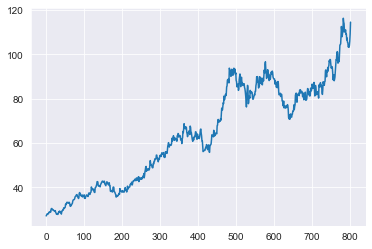

In [13]:
plt.plot(running_mean(total_rewards,50))

So to an extent, this succeeded! Obviously there is so much more to this kind of approach, but at a high level, this is the type of implementation neccessary to create an agent that acts based on a polcy gradient and understand whether or not it succeeded. 